In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
import sys
sys.path.append(module_path)
import time
import datetime
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

import model_management
%load_ext autoreload
%autoreload 1
%aimport data_processing_pso
%aimport plotting_pso
%aimport keras_objects
%aimport pso
from data_processing import *
from plotting_pso import *
from keras_objects import *
from pso import *

np.random.seed(999)
random.seed(999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
### General parameters
run_on_cpu = False
total_set_size = 9 # how many examples will be used for training+validation+testing
train_size = 3
val_size = 3
test_size = 3
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False
outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

### Network parameters
nr_hidden_layers = 10
activation_function = 'relu'
nr_neurons_per_layer = 10
regularisation_strength
std_penalty = False
norm = 'zero_mean_unit_std'


### PSO parameters
nIterations = 500
nParticles = 40
x_min = -10
x_max = 10
alpha = 1
delta_t = 1
c1 = 2
c2 = 2
inertia_weight_start = 1.4
inertia_weight_min = 0.3
exploration_fraction = 0.8
nr_iters_before_restart_check = 20            # start making sure that the network did not converge to a local minimum
min_std_tol = 0.01                # minimum allowed std for any parameter

In [18]:
if run_on_cpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [19]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_nTrainSamples_%d_nIterations_%d_' % (
    nr_hidden_layers, nr_neurons_per_layer, activationFunction, train_size, nIterations)
print(param_string)

nLayers_10_nNeurons_10_actFun_tanh_nTrainSamples_3_nIterations_500_


# Load and preprocess the data

In [5]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                       int(total_set_size), int(train_size), int(val_size), int(test_size))
galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

# Create a new network

In [6]:
network = Feed_Forward_Neural_Network(nr_hidden_layers, nr_neurons_per_lay, input_features, output_features, 
                                      activation_function, output_activation, regularisation_strength)
network.setup_pso({'inertiaWeightMin': 0.1})
network.train_pso(nIterations, training_data_dict, loss_function, 
                  nr_iters_before_restart_check=nr_iters_before_restart_check, speed_check=False, std_penalty=std_penalty)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

#### Get standard pictures

/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<function matplotlib.pyplot.show>

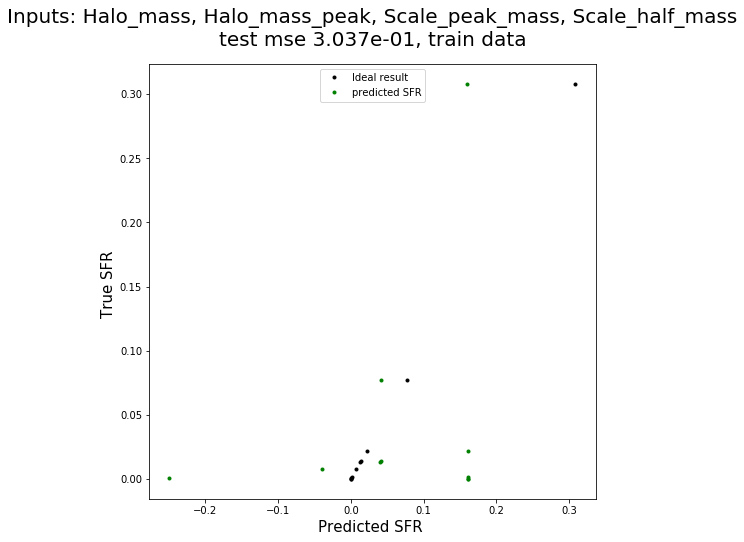

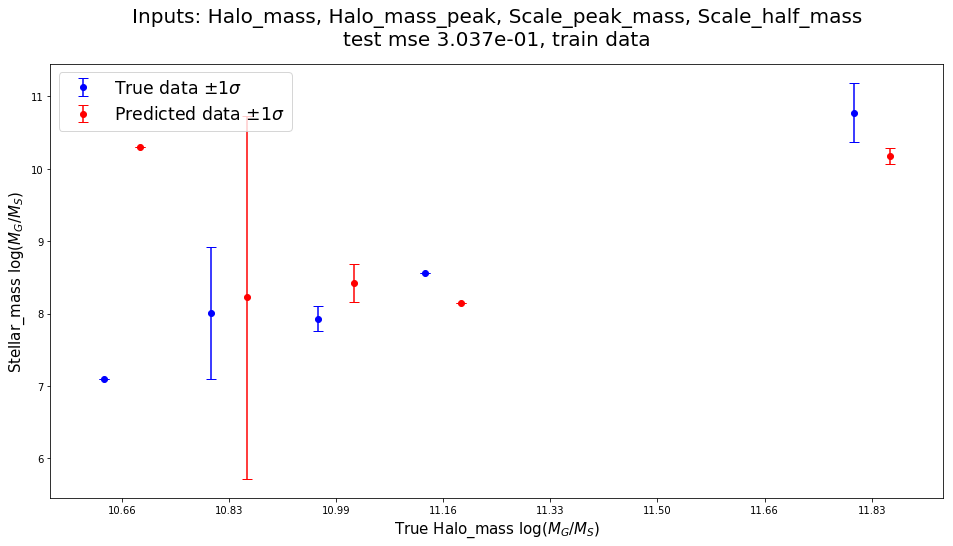

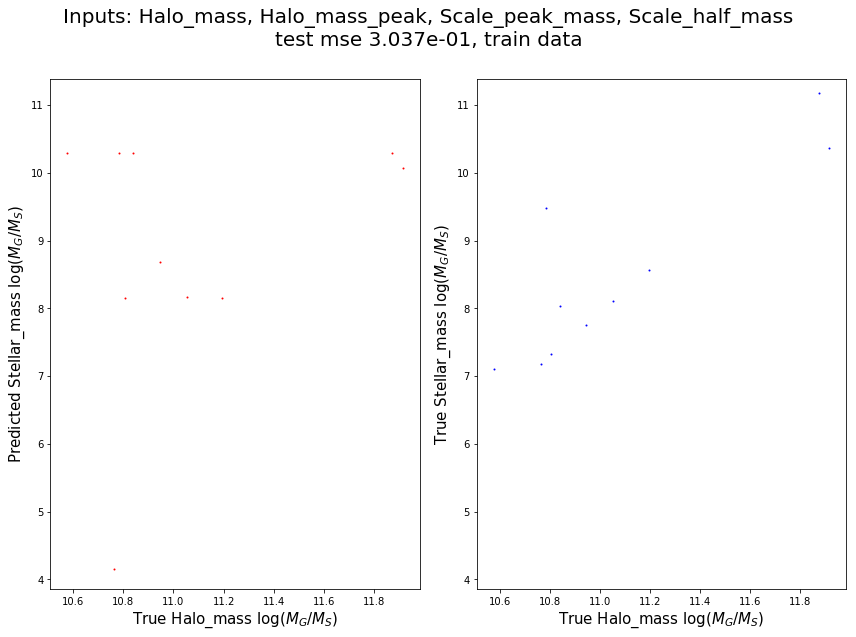

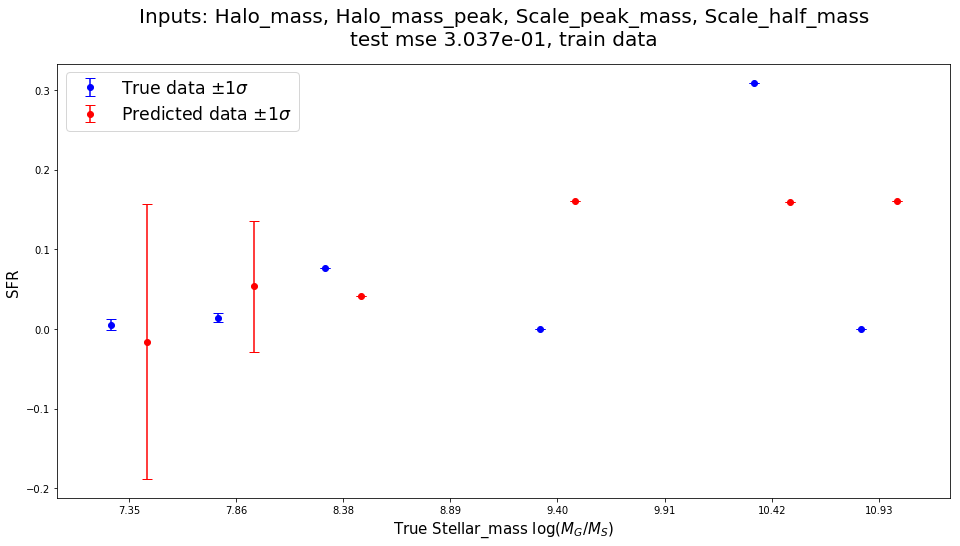

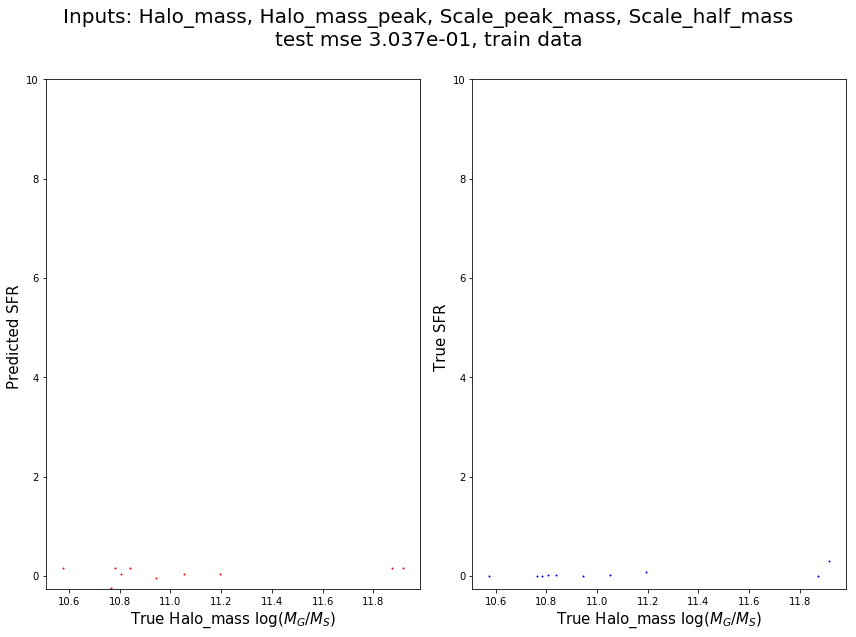

In [16]:
mode = 'train'
network.pso_swarm.set_best_weights('train')
norm_score = network.pso_swarm.evaluate_model(mode)
tot_score = norm_score
model = network.pso_swarm.model
title = 'Inputs: %s\ntest mse %.3e, %s data' % (', '.join(input_features), tot_score, mode)

fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, mode=mode)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, mode=mode)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, mode=mode)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, mode=mode)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 10, y_min = None,
                                    x_min = None, x_max = None, mode=mode)

plt.show

In [ ]:
%matplotlib inline
nBins = 8
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

predictedY = model.predict(x_test)

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig = plt.figure(figsize=(16,16))
    ax = plt.subplot(211)
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    plt.title('nIterations: %d, training set size: %d, test mse score: %.2e\n' % (nIterations, 
        train_size, testScore) + 
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    plt.show
        
    if save_figs:
        fig.savefig(fig_dir+'pso_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_centers.append((bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2)
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
    
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(212)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every boxplot adds 2 boxes, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.boxplot([sorted_true_y_data[iBin], sorted_pred_y_data[iBin]] , positions = bin_pos, widths = 0.9)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers) TODO fixa siffrorna
    plt.text(12,7,'Left: true data. Right: predicted data.', fontsize=20)
    
    if feat == 'SFR':
        ax.axhline(y=0, linestyle='--')
    
    #plt.title('nIterations: %d, training set size: %d, test mse score: %.2e\n' % (nIterations, 
    #    train_size, testScore) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()
    
    if save_figs:
        fig.savefig(fig_dir+'pso_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

In [ ]:
# Summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(trainingScoreHistory, 'b')
plt.plot(validationScoreHistory, 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()